In [35]:
# -*- coding: UTF-8 -*-
from utils import *
from numpy.random import shuffle, choice, normal
from numpy import array, reshape, mean
from cacheout.lfu import LFUCache
from cacheout.lru import LRUCache
import time, gc
from collections import Counter
from pandas import DataFrame
import matplotlib.pyplot as plt
from copy import deepcopy
import multiprocessing

In [168]:
rg = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]

class CocktailModel:
    """
    given a distribution and a trace,
    given the pre-fixed settings of a cache,
    provide the calculated hit rate
    """

    def __init__(self, trace_in_period, cacheSize, history_importance=0.5, globle_file_range=100):
        """
        construct a cocktail model based on the given request pattern in a fixed period of time
        """
        self.cacheSize = cacheSize
        self.period = len(trace_in_period)
        self.history_freq_dict = {}
        self.history_importance = history_importance
        self.bartending_cocktail(trace_in_period)
        self.history_hit_rate = cacheSize / globle_file_range
        self.history_miss = 0
        self.req_count = 0

    def moving_average_for_freq(self, freq_dict, history_freq_dict):
        X, Y = Counter(freq_dict), Counter(history_freq_dict)
        self.history_freq_dict = dict(X + Y)

    def featCacheSize(self):
        """
        find and return kth level index ---- k
        """
        virtualCacheSize = 0
        sortedBucket = sorted(self.bucket.items(), key=lambda x: x[0], reverse=True)
        for item in sortedBucket:
            virtualCacheSize += len(item[1])
            if virtualCacheSize >= self.cacheSize:
                # this indicates that <the recurrence item[0]> is <the k level>
                # (the k th level is most susceptible to replacement)
                return item[0]
        return 0  # None

    def bartending_cocktail(self, trace_in_period):
        self.trace_in_period = trace_in_period
        self.period_freq_dict = freq_dict = count_freq(trace_in_period)
        self.moving_average_for_freq(freq_dict, self.history_freq_dict)
        self.bucket = cluster_by_freq(self.history_freq_dict)
        self.surface_level_freq = self.featCacheSize()

    def calculate_hitrate_theo(self, distribution='sim', params=None):
        """
        provide a quick formula for calculation of hit rate
        """
        self.req_count += self.period
        if distribution == 'absolute order':
            if not self.surface_level_freq:
                miss = 0
                print("not surface_level_freq")
            else:
                miss = len([k for k, v in self.period_freq_dict.items() if v == self.surface_level_freq])
            self.history_hit_rate = 0.5 * (self.history_hit_rate + (1 - miss / self.period))  # serious bug
            return self.history_hit_rate
        elif distribution == 'sim':
            if not self.surface_level_freq:
                miss = 0  # should be the prob that the requested item is in cache * self.period
                print("not surface_level_freq")
            else:
                # miss = len([k for k, v in self.period_freq_dict.items() if v <= self.surface_level_freq])
                losers = [k for k, v in self.period_freq_dict.items() if v <= self.surface_level_freq]
                miss = sum([int(i in losers) for i in self.trace_in_period])
            self.history_miss += miss
            self.history_hit_rate = 1 - self.history_miss / self.req_count
            return self.history_hit_rate
        elif distribution == 'exp':
            pass
        elif distribution == 'zipf':
            pass


class RealCache:
    """
    create a realCache using the 'cacheout' lib
    """

    def __init__(self, cacheSize, policy='LFU'):
        if policy == 'LFU':
            self.cache = LFUCache(maxsize=cacheSize, ttl=0, timer=time.time, default=None)
        elif policy == 'LRU':
            self.cache = LRUCache(maxsize=cacheSize, ttl=0, timer=time.time, default=None)
        self.hit, self.miss = 0, 0

    def handle_request(self, req):
        if self.cache._has(req):
#             print(req,'hit', self.cache.keys())
            self.hit += 1
        else:
            self.cache._add(req, 1)
#             print(req,'miss', self.cache.keys())
            self.miss += 1

    def hit_rate(self, trace):
        """
        return hit rate for trace
        """
        for req in trace:
            self.handle_request(req)
        return self.hit / (self.hit + self.miss + 0.01)  # hit rate

-0.32669966000013606
-0.3472596453281418
-0.31055963840014467
-0.22973962870414866
-0.20411961835215275
-0.16847961260815503
-0.1275596089761567
-0.0858396056641576
-0.03971960411215869


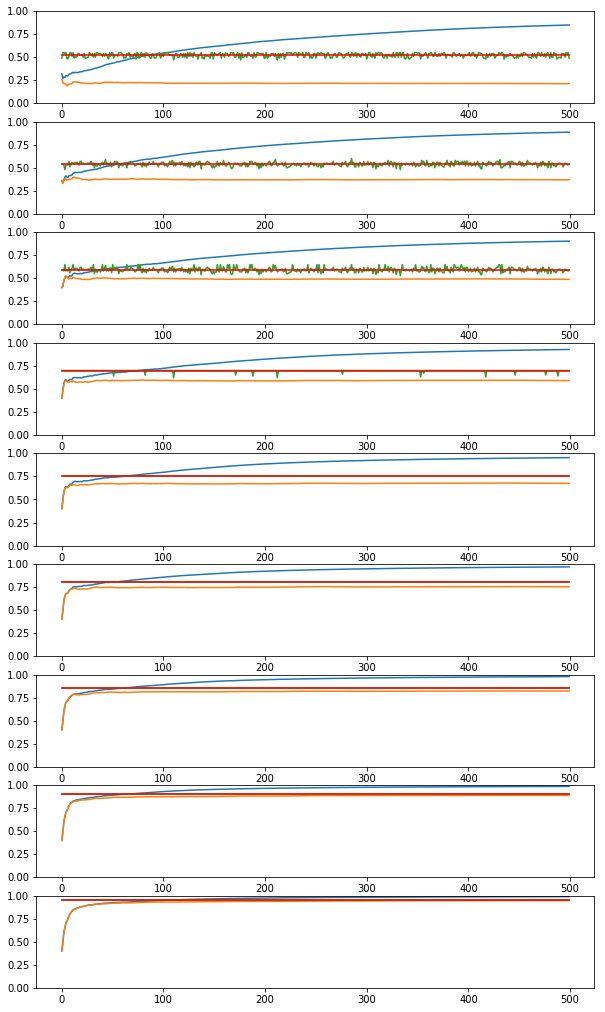

In [37]:
%matplotlib inline
# plt.ion()
num_stages = 500
file_range = 100
traceGenerator = TraceGenerator()
trace = [traceGenerator.generate_zipf(n=file_range, alpha=0.7, num_samples=50) for i in range(num_stages)]
plt.figure(figsize=(10, 20))

# print('zipf: n=100, alpha=0.7, num_samples=50')

# trace = [traceGenerator.generate_exponential(scale=15) for i in range(num_stages)]
# print('exp: n=100, scale=10')

# trace = [list(traceGenerator.generate_normal(sigma=15)) for i in range(num_stages)]
# print('normal: mu=0, sigma=25')

# lst = []
# st = set()
# for t in trace:
#     st = st | set(t)
#     lst.append(len(st))  # count the unique elements in trace
# print(lst)

for cache_Size in range(10, 100, 10):
    global_plot_record = {'lfu': [], 'lru': [],
                          # 0.: [], 0.1: [], 0.2: [], 0.3: [], 0.4: [], 0.5: [], 0.6: [],
                          # 0.7: [], 0.8: [], 0.9: [], 1: [],
                          'cocktail': []}
    real_cache_lfu = RealCache(cache_Size, 'LFU')
    real_cache_lru = RealCache(cache_Size, 'LRU')

    last_cocktail = None
    cocktails = None
    kth_level = []

    for period_trace in trace:
        cocktail = CocktailModel(period_trace, cache_Size, globle_file_range=file_range)  # if zipf
        global_plot_record['lfu'].append(real_cache_lfu.hit_rate(period_trace))
        global_plot_record['lru'].append(real_cache_lru.hit_rate(period_trace))
        cocktail.bartending_cocktail(period_trace)
        global_plot_record['cocktail'].append(cocktail.calculate_hitrate_theo())
        kth_level.append(cocktail.surface_level_freq)

    # print('cache_Size:', cache_Size, global_plot_record['cocktail'])
    # print('bucket', cocktail.bucket)
    # print('kth_level', kth_level)
    # print([i for i in zip(global_plot_record['cocktail'], kth_level)])

#     plt.subplot(16, 1, (cache_Size-8) // 2)
    plt.subplot(10, 1, cache_Size // 10)
    for i in global_plot_record:
        plt.plot(global_plot_record[i])
    m = mean(global_plot_record['cocktail'])
    plt.ylim(0, 1)
    print(m - global_plot_record['lfu'][-1])
    plt.plot([0, 499], [m, m], c='r')
    # plt.pause(3)
    # gc.collect()
# plt.ioff()
plt.show()

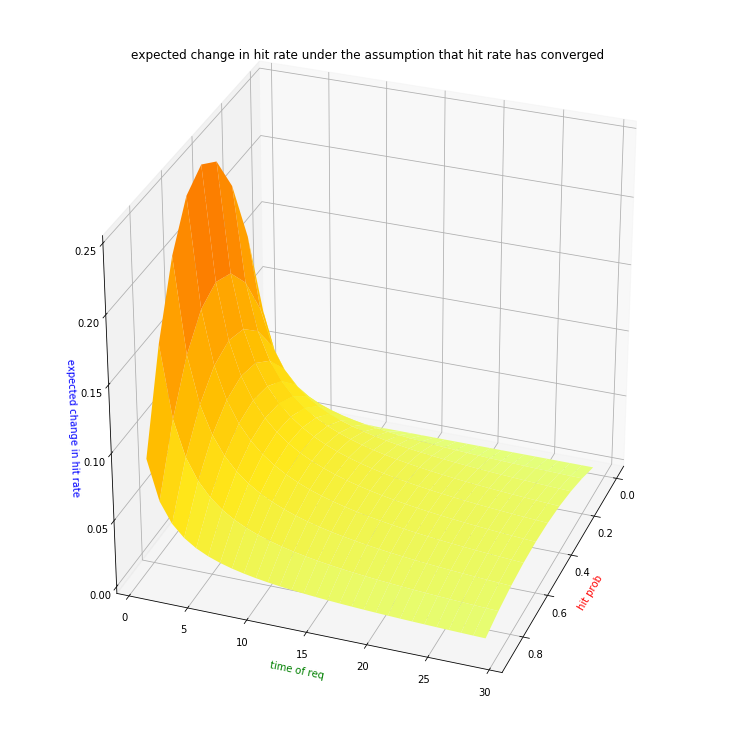

In [34]:
%matplotlib inline
from numpy import linspace
from mpl_toolkits.mplot3d import Axes3D

def expected_delta_hitrate(p,N):
    return 2*(p-p**2)/(N+1)

fig1=plt.figure(figsize=(10, 10))
ax=Axes3D(fig1)

X=np.arange(0,1,0.1)  
Y=np.arange(1,30,1)
X,Y=np.meshgrid(X,Y)
# X,Y=np.mgrid[0:1:40j,1:1000:40j]
Z=expected_delta_hitrate(X,Y)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.Wistia)
plt.title("expected change in hit rate under the assumption that hit rate has converged")
ax.view_init(30, 20)
ax.set_xlabel('hit prob', color='r')  
ax.set_ylabel('time of req', color='g')  
ax.set_zlabel('expected change in hit rate', color='b')
plt.show()

In [51]:
from cacheout.lfu import LFUCache
cache = LFUCache(maxsize=4, ttl=0, timer=time.time, default=None)
for i in range(4):
    cache.add(1,1)
    cache.add(2,1)
for i in range(3):
    cache.add(3,1)
    cache.add(4,1)
cache.add(5,1)
cache.add(6,1)
cache.keys()

odict_keys([1, 2, 3, 4, 6])

In [52]:
from cacheout.lru import LRUCache
cache = LRUCache(maxsize=4, ttl=0, timer=time.time, default=None)
for i in range(4):
    cache.add(1,1)
    cache.add(2,1)
for i in range(3):
    cache.add(3,1)
    cache.add(4,1)
cache.add(5,1)
cache.add(6,1)
cache.keys()

odict_keys([3, 4, 5, 6])

In [127]:
a=list('8bBb0a667a1a5BbbAFCDE8Fabbb9bDD1E9bBA2043DB2ABaE2babFBaba6bEFEDB6aC9ECA') #*100
# a=[1,2,3,4,5,6,7,8,9,0]*3+['A','B','C','D','E','F']*5+['a','b']*6
# shuffle(a)

In [123]:
c=RealCache(10,'LFU')
c.hit_rate(a)

A miss odict_keys(['A'])
C miss odict_keys(['A', 'C'])
2 miss odict_keys(['A', 'C', 2])
b miss odict_keys(['A', 'C', 2, 'b'])
B miss odict_keys(['A', 'C', 2, 'b', 'B'])
a miss odict_keys(['A', 'C', 2, 'b', 'B', 'a'])
C hit odict_keys(['A', 'C', 2, 'b', 'B', 'a'])
C hit odict_keys(['A', 'C', 2, 'b', 'B', 'a'])
a hit odict_keys(['A', 'C', 2, 'b', 'B', 'a'])
7 miss odict_keys(['A', 'C', 2, 'b', 'B', 'a', 7])
5 miss odict_keys(['A', 'C', 2, 'b', 'B', 'a', 7, 5])
a hit odict_keys(['A', 'C', 2, 'b', 'B', 'a', 7, 5])
3 miss odict_keys(['A', 'C', 2, 'b', 'B', 'a', 7, 5, 3])
F miss odict_keys(['A', 'C', 2, 'b', 'B', 'a', 7, 5, 3, 'F'])
1 miss odict_keys(['C', 2, 'b', 'B', 'a', 7, 5, 3, 'F', 1])
A miss odict_keys(['C', 'b', 'B', 'a', 7, 5, 3, 'F', 1, 'A'])
F hit odict_keys(['C', 'b', 'B', 'a', 7, 5, 3, 'F', 1, 'A'])
0 miss odict_keys(['C', 'B', 'a', 7, 5, 3, 'F', 1, 'A', 0])
8 miss odict_keys(['C', 'a', 7, 5, 3, 'F', 1, 'A', 0, 8])
A hit odict_keys(['C', 'a', 7, 5, 3, 'F', 1, 'A', 0, 8])
7 hit o

0.40272184418830714

In [128]:
from collections import OrderedDict
cocktail = CocktailModel(a, 10, 18)
print(cocktail.calculate_hitrate_theo())
print(OrderedDict(sorted(cocktail.period_freq_dict.items(),reverse=True, key=lambda t: t[1])))

0.7323943661971831
OrderedDict([('b', 13), ('a', 9), ('B', 7), ('E', 6), ('D', 5), ('F', 4), ('A', 4), ('6', 4), ('2', 3), ('C', 3), ('9', 3), ('1', 2), ('8', 2), ('0', 2), ('7', 1), ('4', 1), ('5', 1), ('3', 1)])


In [125]:
g=OrderedDict(sorted(cocktail.period_freq_dict.items(),reverse=True, key=lambda t: t[1])).values()
hit=sum([i for i in g if i>3])
all=sum(g)
hit/all

0.5833333333333334

In [182]:
import numpy as np
class CocktailLRU:
    """
    given a distribution and a trace,
    given the pre-fixed settings of a cache,
    provide the calculated hit rate
    """
    def file_req_time_mapping(self, whole_trace, all_diff=False):
        self.file_req_time_map = {}
        self.num_distinct_files_between_reqs_for_same_file = {}
        t = 0
        for i in whole_trace:
            t += 1
            if i not in self.file_req_time_map:
                self.file_req_time_map[i] = []  
            self.file_req_time_map[i].append(t)
            
            if all_diff:    
                if i not in self.num_distinct_files_between_reqs_for_same_file:
                    self.num_distinct_files_between_reqs_for_same_file[i] = array()
                else:
                    ndf = whole_trace[self.file_req_time_map[i][-2] + 1 : t]
                    np.append(self.num_distinct_files_between_reqs_for_same_file[i],len(set(ndf)))
        if not all_diff:
            for i in set(whole_trace):
                tmp = array(self.file_req_time_map[i])
                self.num_distinct_files_between_reqs_for_same_file[i] = tmp[1:] - tmp[:-1]
                
    def calc_misses(self,cs):
        misses=0
        for i in self.num_distinct_files_between_reqs_for_same_file:
            tmp=array(self.num_distinct_files_between_reqs_for_same_file[i])
            misses+=len(tmp[tmp>cs])

In [156]:
c2=CocktailLRU()
c2.file_req_time_mapping(a, True)
c2.num_distinct_files_between_reqs_for_same_file

{'8': [14],
 'b': [1, 7, 0, 7, 0, 0, 1, 5, 10, 1, 3, 2],
 'B': [7, 11, 6, 2, 6, 7],
 '0': [16],
 'a': [3, 1, 9, 12, 3, 3, 1, 7],
 '6': [0, 17, 5],
 '7': [],
 '1': [12],
 '5': [],
 'A': [11, 7, 11],
 'F': [4, 13, 5],
 'C': [16, 2],
 'D': [6, 0, 10, 9],
 'E': [7, 10, 6, 1, 6],
 '9': [4, 14],
 '2': [5, 4],
 '4': [],
 '3': []}

In [157]:
file_range = 500
traceGenerator = TraceGenerator()
trace = traceGenerator.generate_zipf(n=file_range, alpha=0.7, num_samples=500000)

In [166]:
with open('trace.txt', 'w') as f:
    f.write(str(trace))

In [161]:
c2=CocktailLRU()
c2.file_req_time_mapping(trace, True)
ndf=c2.num_distinct_files_between_reqs_for_same_file

In [165]:
with open('ndf.json', 'w') as f:
    f.write(str(ndf))

In [186]:
for cs in range(20,340,40):
    c=RealCache(cs,'LRU')
    print(cs, c.hit_rate(trace))

20 0.13584999728300004
60 0.3063659938726801
100 0.42249199155016015
140 0.5153979896920402
180 0.5935259881294802
220 0.6625359867492803
260 0.7246639855067203
300 0.7804859843902803


In [195]:
trace = traceGenerator.generate_zipf(n=file_range, alpha=0.7, num_samples=500000)
for cs in range(20,340,40):
    c=RealCache(cs,'LRU')
    print(cs, c.hit_rate(trace))

20 0.13634799727304006
60 0.30656799386864014
100 0.42210399155792017
140 0.5145679897086401
180 0.5924619881507602
220 0.6609619867807602
260 0.7226899855462002
300 0.7787399844252003


In [185]:
for cs in range(20,340,40):
    misses=0
    for i in c2.num_distinct_files_between_reqs_for_same_file:
        tmp=array(c2.num_distinct_files_between_reqs_for_same_file[i])
        misses+=len(tmp[tmp>cs])
    print(1-misses/5e5)

0.14172799999999997
0.30976000000000004
0.42488000000000004
0.517512
0.595282
0.664088
0.726064
0.78183


In [191]:
sorted([(k,len(v)/5e5) for k,v in c2.num_distinct_files_between_reqs_for_same_file.items()])

[(0, 0.052852),
 (1, 0.03258),
 (2, 0.02518),
 (3, 0.020208),
 (4, 0.017384),
 (5, 0.01513),
 (6, 0.013478),
 (7, 0.012506),
 (8, 0.011584),
 (9, 0.01098),
 (10, 0.009848),
 (11, 0.009324),
 (12, 0.008734),
 (13, 0.008474),
 (14, 0.007956),
 (15, 0.007698),
 (16, 0.007306),
 (17, 0.007212),
 (18, 0.006632),
 (19, 0.006554),
 (20, 0.006414),
 (21, 0.006378),
 (22, 0.006024),
 (23, 0.005614),
 (24, 0.00557),
 (25, 0.005612),
 (26, 0.005416),
 (27, 0.005078),
 (28, 0.005112),
 (29, 0.004962),
 (30, 0.004786),
 (31, 0.004654),
 (32, 0.004736),
 (33, 0.004484),
 (34, 0.00454),
 (35, 0.004504),
 (36, 0.004152),
 (37, 0.004388),
 (38, 0.004078),
 (39, 0.004066),
 (40, 0.004078),
 (41, 0.003786),
 (42, 0.003902),
 (43, 0.003654),
 (44, 0.003866),
 (45, 0.00378),
 (46, 0.003578),
 (47, 0.003562),
 (48, 0.003594),
 (49, 0.003478),
 (50, 0.003362),
 (51, 0.00329),
 (52, 0.003314),
 (53, 0.003252),
 (54, 0.003294),
 (55, 0.003236),
 (56, 0.00331),
 (57, 0.003096),
 (58, 0.002868),
 (59, 0.003198),

In [193]:
z=np.array([1/i**0.7 for i in range(1,501)])
z/sum(z)

array([0.05337728, 0.03285757, 0.0247384 , 0.02022621, 0.01730125,
       0.01522827, 0.01367061, 0.01245069, 0.01146533, 0.01065017,
       0.0099628 , 0.0093741 , 0.00886331, 0.00841525, 0.00801849,
       0.0076643 , 0.00734585, 0.00705774, 0.00679562, 0.00655595,
       0.00633582, 0.00613282, 0.00594493, 0.00577044, 0.00560788,
       0.00545601, 0.00531376, 0.00518019, 0.0050545 , 0.00493596,
       0.00482396, 0.00471793, 0.00461739, 0.0045219 , 0.00443107,
       0.00434455, 0.00426202, 0.00418319, 0.00410782, 0.00403566,
       0.0039665 , 0.00390016, 0.00383644, 0.0037752 , 0.00371627,
       0.00365954, 0.00360486, 0.00355212, 0.00350122, 0.00345205,
       0.00340453, 0.00335857, 0.00331408, 0.003271  , 0.00322926,
       0.00318878, 0.00314952, 0.00311141, 0.0030744 , 0.00303844,
       0.00300349, 0.00296949, 0.00293642, 0.00290423, 0.00287288,
       0.00284234, 0.00281257, 0.00278356, 0.00275526, 0.00272764,
       0.0027007 , 0.00267438, 0.00264869, 0.00262358, 0.00259

In [194]:
for cs in range(20,340,40):
    cocktail = CocktailModel(trace, cs, 500)
    print(cs,cocktail.calculate_hitrate_theo())

20 0.285104
60 0.458978
100 0.560362
140 0.635976
180 0.697568
220 0.74993
260 0.796152
300 0.837604
